In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate



## Credit Risk Prediction Project

Description: The goal of this analysis is to develop a model that asseses whether an individual as demonstrated 90 days past due delinquency or worse dependign on finanxial features and individual characteristics. This project will use the "Give Me Some Credit" dataset from Kaggle. 

Credit Fusion and Will Cukierski. Give Me Some Credit. https://kaggle.com/competitions/GiveMeSomeCredit, 2011. Kaggle.

In [2]:
credit_traindf = pd.read_csv("data/cs-training.csv")
credit_testdf = pd.read_csv("data/cs-test.csv")

In [3]:
credit_traindf

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


The training dataset contains long confusing columns, these will be rennamed to simplify the features. Also, one of the columns will be removed because it is not useful, appears to be the index column ("Unnamed : 0").

In [4]:
new_columns = {
    "SeriousDlqin2yrs" : "target",
    "RevolvingUtilizationOfUnsecuredLines" : "credit_util_ratio",
    "NumberOfTime30-59DaysPastDueNotWorse" : "mod_late_count_2yr",
    "DebtRatio": "debt_ratio",
    "MonthlyIncome" : "monthly_income",
    "NumberOfOpenCreditLinesAndLoans" : "credit_loans_count", 
    "NumberOfTimes90DaysLate" : "crit_late_count", 
    "NumberRealEstateLoansOrLines" : "real_estate_count",
    "NumberOfTime60-89DaysPastDueNotWorse"  :"sev_late_count_2yr",
    "NumberOfDependents" : "dependent_count"
}


credit_traindf = credit_traindf.rename(columns = new_columns)
credit_testdf = credit_testdf.rename(columns = new_columns)

credit_traindf

,Unnamed: 0,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [5]:
credit_traindf = credit_traindf.drop(columns = ["Unnamed: 0"])
credit_testdf = credit_testdf.drop(columns = ["Unnamed: 0"])

credit_traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   target              150000 non-null  int64  
 1   credit_util_ratio   150000 non-null  float64
 2   age                 150000 non-null  int64  
 3   mod_late_count_2yr  150000 non-null  int64  
 4   debt_ratio          150000 non-null  float64
 5   monthly_income      120269 non-null  float64
 6   credit_loans_count  150000 non-null  int64  
 7   crit_late_count     150000 non-null  int64  
 8   real_estate_count   150000 non-null  int64  
 9   sev_late_count_2yr  150000 non-null  int64  
 10  dependent_count     146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


Observing the dataset, it appears that the features for monthly income and dependent count contain missing values. The monthly income is particularly not good because there is about 20% of the data missing, and another column, the debt ratio is directly affected. The debt ratio is calculated by dividing monthly debt payments, alimony and living costs by the monthly income. But for rows containing a missing monthly income, the debt ratio is a whole number (not ratio), indicating that those examples were not correctly calucated with the monthly income, and instead may have been computed simply by dividing by 1. Since we are not sure what the monthly income is, we cannot be confident in the debt ratio. The depenedent count is less severe and only accounts for about 7 percent of the total data. 

We will use the KNNImputer to imptute the missing values in monthly income and create a custom transformer to update the debt ratio, called update_dept_ratio. Could potentially also create a missingness flag in feature engineering. We could remove the rows that do not contain the dependent count, since there is a much lesser number of these cases.

### 1. Exploratory Data Analysis

> There is a moderate class imbalance for the target feature, there is notably more cases of individuals that do not have a 90+ due dilenquency (~93%), and individuals with this characteristic is the minority (~7%). This could risk of the model overfitting, and not doing well on the minority class, we need to ensure that downstream metric results acknowledge this.  

> Some of the data appears to have outliers based on the statistics summary, there are very large max values. This will be further investigated. There is also some weird data such as the min age at 0. Based on summary statistics moderate/severe/crit late counts are not very common, but appear to be very high for a select few people (not within the IQR ranges). 

> From the boxplots, we see that there are many outliers in the data. The columns that show particularly a few extreme values include age,  the columns that are particular concerning are age, credit utiliation ratio, moderate/severe/crit late counts and credit utilization ratio. We can modify these by eliminated the extreme outliers. 
Note that the debt ratio column also has notably large outliers, but this may becuase some of the data is not properly normalized due to the missing monthly income, we can check this again once the monthly income column is imputed. The

> Its beneficial to decretialize the age feature for linear models like linear regression, but it will not be that useful for tree-based models or XGBoost (review this).

> From the heatmap, we see that there are high positive correlations between moderate late count (2 years), severe late count (2 years) and critical late count. Our options are to eliminate two of these features or perform feature engineering to combine them or create a new features. 

Individuals in this dataset with 90+ days past due Delinquency: 10026 (6.68%)
Individuals in this dataset without 90+ days past due Delinquency: 139974 (93.32%)


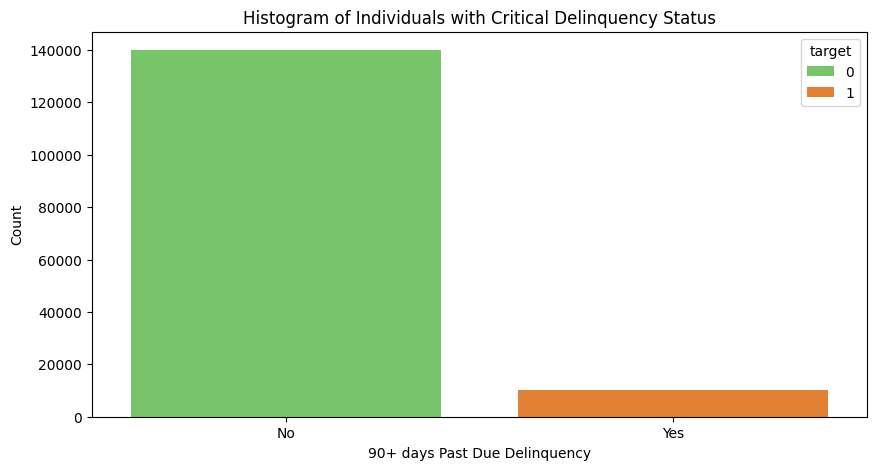

In [6]:
# Make a histogram displaying the counts of the target column

yes_cases = credit_traindf[credit_traindf["target"] == 1].shape[0]
no_cases = credit_traindf[credit_traindf["target"] == 0].shape[0]
total = credit_traindf.shape[0]

yes_cases_percent, no_cases_percent = (yes_cases / total)*100, (no_cases / total)*100

print(f"Individuals in this dataset with 90+ days past due Delinquency: {yes_cases} ({yes_cases_percent:.2f}%)")
print(f"Individuals in this dataset without 90+ days past due Delinquency: {no_cases} ({no_cases_percent:.2f}%)")


plt.figure(figsize = (10,5))
sns.countplot(x = "target",
              data = credit_traindf,
              hue = "target", 
              palette={0 : "#6DD558", 1 : "#FF7C17"})
plt.title("Histogram of Individuals with Critical Delinquency Status")
plt.xlabel("90+ days Past Due Delinquency")
plt.ylabel("Count")
plt.xticks(ticks = [0, 1], labels=['No', 'Yes'])
plt.show()

In [7]:
credit_traindf.describe()

,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


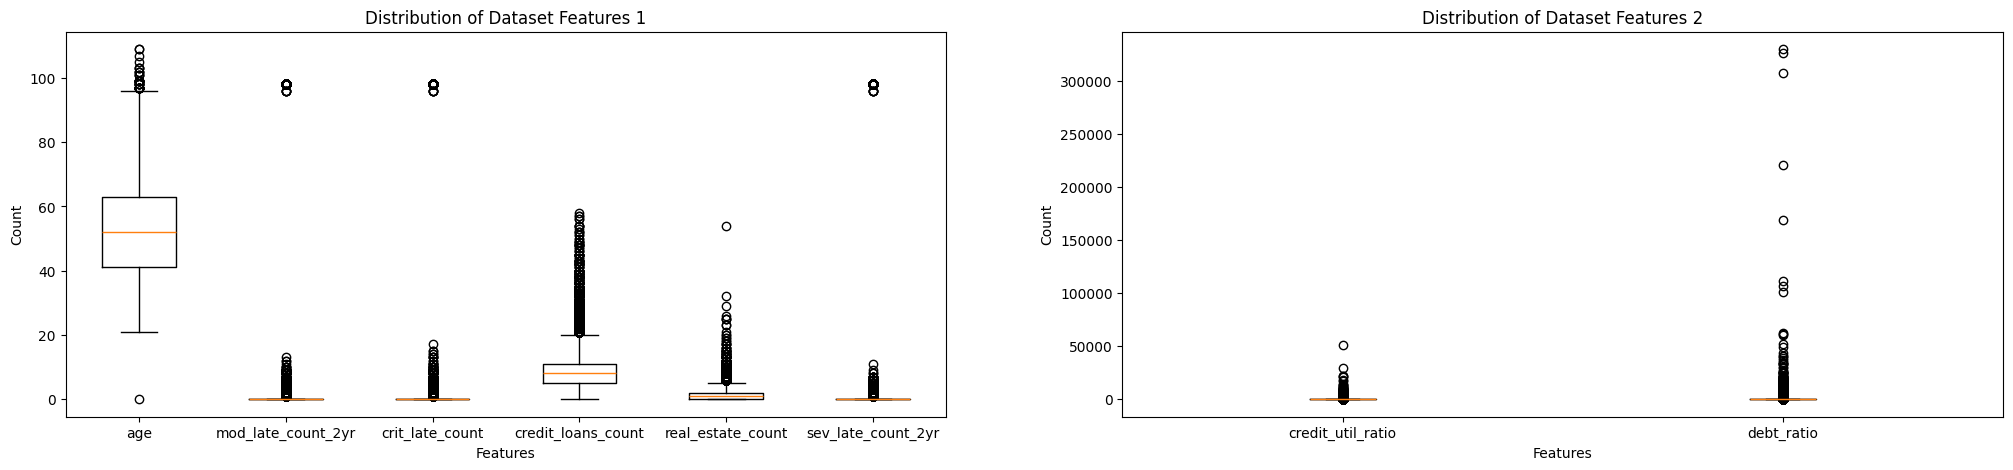

In [8]:
columns_0 = credit_traindf[["age", "mod_late_count_2yr", "crit_late_count", "credit_loans_count", "real_estate_count", "sev_late_count_2yr", ]]
columns_1 = credit_traindf[["credit_util_ratio", "debt_ratio", ]]

fig, ax = plt.subplots(1,2, figsize=(25,5))

ax[0].set_title("Distribution of Dataset Features 1")
ax[0].boxplot(columns_0)
ax[0].set_xticks(ticks = range(1,7), labels = columns_0)
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Features")

ax[1].set_title("Distribution of Dataset Features 2")
ax[1].boxplot(columns_1)
ax[1].set_xticks(ticks = range(1,3), labels = columns_1)
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Features")



plt.show()

<Axes: xlabel='monthly_income'>

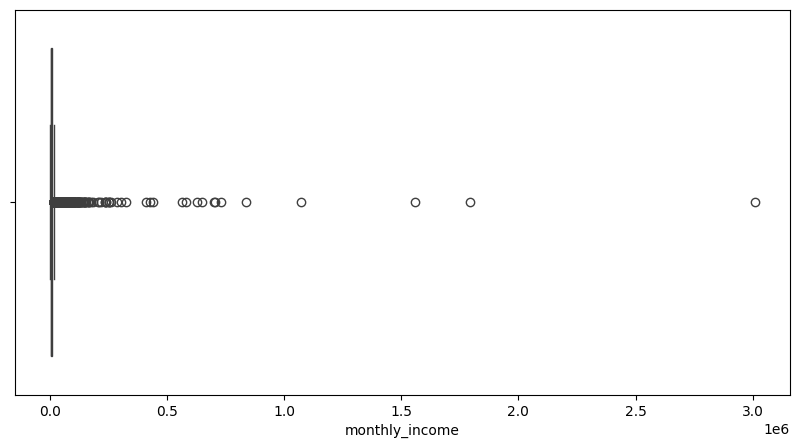

In [9]:
plt.figure(figsize = (10,5))
sns.boxplot(x = credit_traindf["monthly_income"])


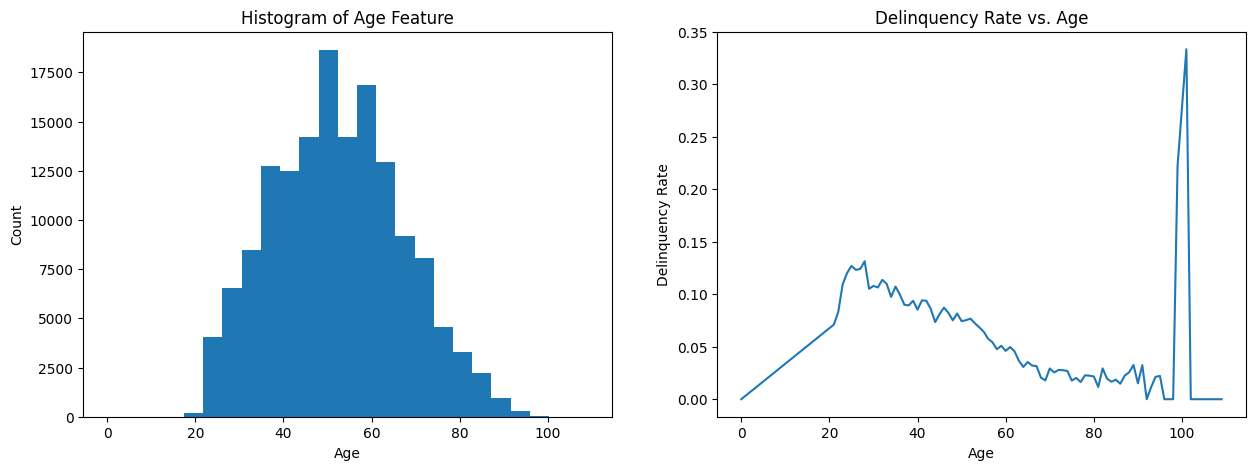

In [10]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].hist(credit_traindf["age"], bins =25)
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of Age Feature")

age_target_rate = credit_traindf.groupby("age")["target"].mean() #!!!!

ax[1].plot(age_target_rate.index, age_target_rate.values)
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Delinquency Rate")
ax[1].set_title("Delinquency Rate vs. Age")


plt.show()

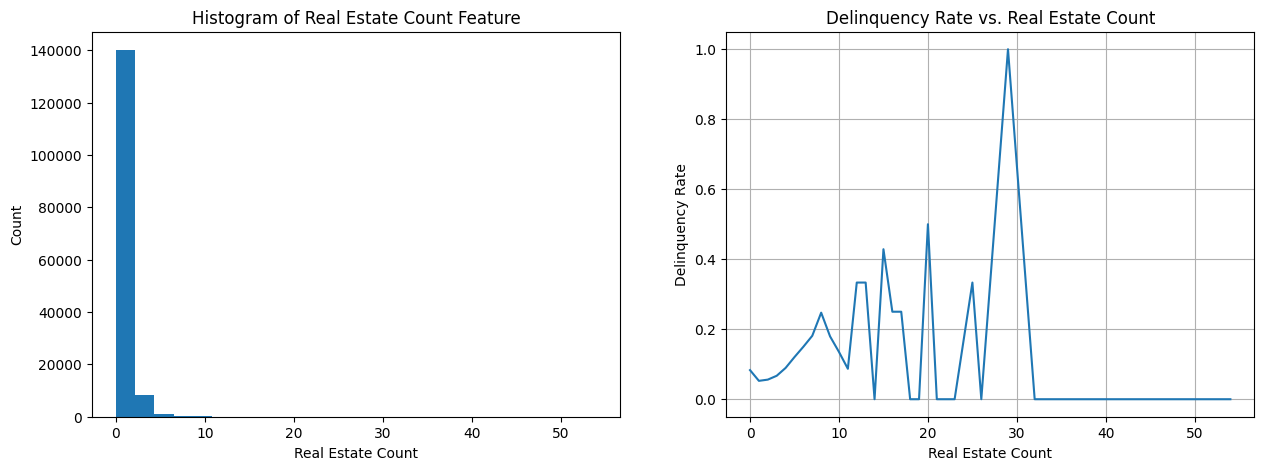

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].hist(credit_traindf["real_estate_count"], bins =25)
ax[0].set_xlabel("Real Estate Count")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of Real Estate Count Feature")

age_target_rate = credit_traindf.groupby("real_estate_count")["target"].mean() #!!!!

ax[1].plot(age_target_rate.index, age_target_rate.values)
ax[1].set_xlabel("Real Estate Count")
ax[1].set_ylabel("Delinquency Rate")
ax[1].set_title("Delinquency Rate vs. Real Estate Count")
ax[1].grid(True)


plt.show()

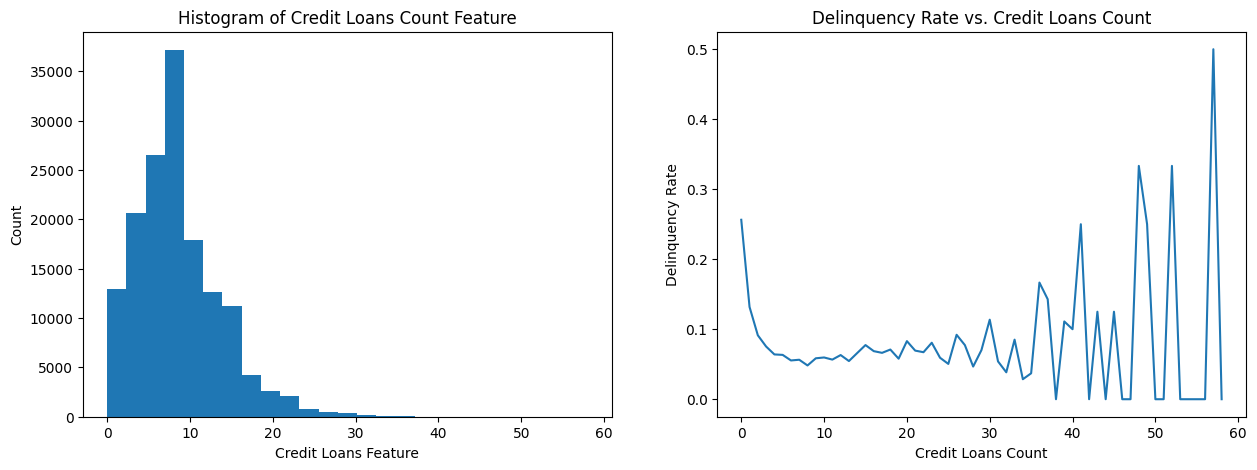

In [12]:
fig, ax = plt.subplots(1,2, figsize = (15,5))      

ax[0].hist(credit_traindf["credit_loans_count"], bins =25)
ax[0].set_xlabel("Credit Loans Feature")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of Credit Loans Count Feature")

age_target_rate = credit_traindf.groupby("credit_loans_count")["target"].mean() #!!!!

ax[1].plot(age_target_rate.index, age_target_rate.values)
ax[1].set_xlabel("Credit Loans Count")
ax[1].set_ylabel("Delinquency Rate")
ax[1].set_title("Delinquency Rate vs. Credit Loans Count")


plt.show()

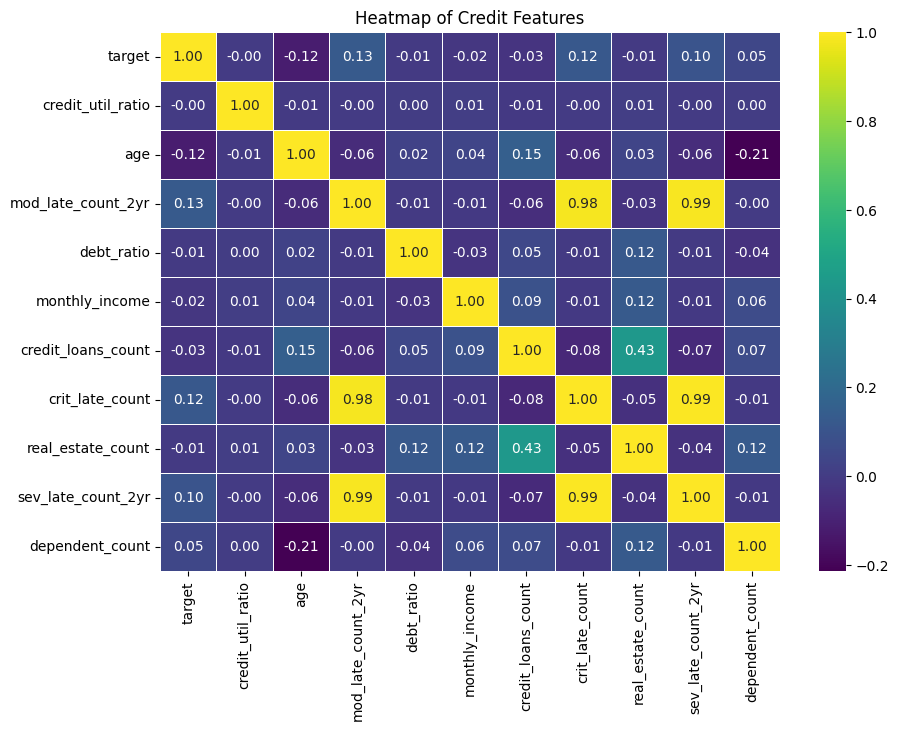

In [13]:
# Create a Heatmap to show correlations between features 
corr_subset = credit_traindf[credit_traindf.columns[:1000]].corr()

plt.figure(figsize=(10, 7)) 
sns.heatmap(corr_subset, annot=True, cmap='viridis', fmt=".2f", linewidths=.5) 
plt.title('Heatmap of Credit Features') 
plt.show()

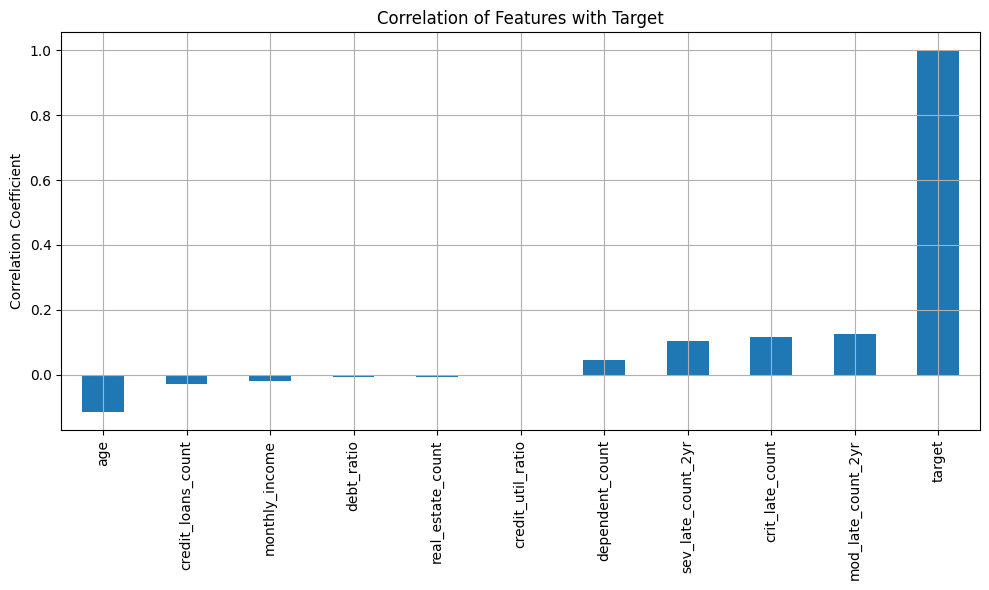

In [14]:
# plot correlations between features and the target

correlations = credit_traindf.corr(numeric_only=True)["target"].sort_values()

# Plot
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.title("Correlation of Features with Target")
plt.ylabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Feature Engineering + Preprocessing

> Really useful look, should look into afterwards: https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets

> For feature engineering, we will ignore the class imbalance for now, it is moderate so we will first see how the models react before improving this. We will trim some of the columns that appear to have extreme outliers as mentioned in the EDA. Finally, we will try averaging the values with high correlations to reduce the risk of multicolinearity.

In [15]:
traindf = credit_traindf.copy()
testdf = credit_testdf.copy()

In [16]:
def preprocess(df) :

    '''Before splitting, perform preprocessing '''

    # Make the columns binary (0: for zero counts, 1: for 1+ counts) ✓✓
    make_binary_cols = ["crit_late_count", "mod_late_count_2yr", "sev_late_count_2yr"]

    for col in make_binary_cols : 
        df[col] = (df[col] > 0).astype(int)
        # (df[col] > 0) returns a series of booleans, which is turned into 1 (True) or 0 (False)


    # Remove bad rows from the age column (above 100, less than 18 years old) ✓✓
    df["age_clipped"] = df["age"].clip(upper=100, lower=18)
    #df = df.drop(columns = "age") 

    # Binning Age, credit loans, real estate bin ✓✓
    df['age_bin'] = pd.cut(df['age_clipped'], 
                           bins=[-float('inf'), 30, 45, 60, float('inf')], 
                           labels=False)
    
    df['credit_bin'] = pd.cut(df['credit_loans_count'], 
                              bins=[-float('inf'), 5, 25, 40, float('inf')], 
                              labels=False)

    df['real_estate_bin'] = pd.cut(df['real_estate_count'], 
                                   bins=[-float('inf'), 10, 20, 30, float('inf')], 
                                   labels=False)


    remove_col = ["age_clipped","age", "credit_loans_count", "real_estate_count"]
    df = df.drop(columns = remove_col)

    # Add a missingness flag for the monthly_income column ✓✓
    df["mon_income_miss"] = df["monthly_income"].isna().astype(int)

    # cap the ratio columns at 1, and flag any rows > 1 in a new feature ✓✓
    ratio_cols = ["credit_util_ratio", "debt_ratio"]

    for col in ratio_cols : 
        df[f"{col}_outliers"] = (df[col] > 1).astype(int)
        df.loc[df[col] > 1, col] = 1


    return df

In [17]:
traindf_processed = preprocess(traindf)
testdf_preprocessed = preprocess(testdf)

In [28]:
traindf_processed.describe()

,target,credit_util_ratio,mod_late_count_2yr,debt_ratio,monthly_income,crit_late_count,sev_late_count_2yr,dependent_count,age_bin,credit_bin,real_estate_bin,mon_income_miss,credit_util_ratio_outliers,debt_ratio_outliers
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,146076.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,0.319196,0.159880,0.466287,6.670221e+03,0.055587,0.050693,0.757222,1.886647,0.697407,0.000707,0.198207,0.022140,0.234247
std,0.249746,0.349481,0.366496,0.355455,1.438467e+04,0.229123,0.219371,1.115086,0.919103,0.477360,0.029880,0.398650,0.147139,0.423528
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,0.000000,0.175074,3.400000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,0.000000,0.366508,5.400000e+03,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.559046,0.000000,0.868254,8.249000e+03,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,3.008750e+06,1.000000,1.000000,20.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000


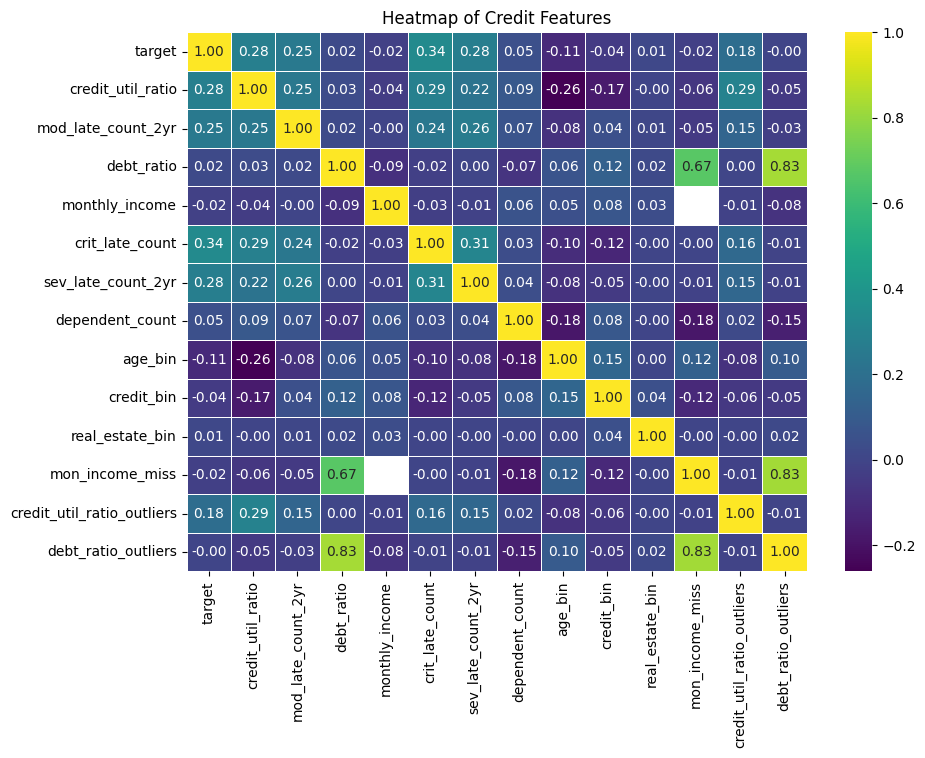

In [18]:
corr_subset = traindf_processed[traindf_processed.columns[:1000]].corr()

plt.figure(figsize=(10, 7)) 
sns.heatmap(corr_subset, annot=True, cmap='viridis', fmt=".2f", linewidths=.5) 
plt.title('Heatmap of Credit Features') 
plt.show()

In [45]:
# Split the training set into a testing and training set to get validation
X = traindf_processed.drop(columns = ["target"])
y = traindf_processed[["target"]]

# splitting on 0.5 because we have a lot of data and it's slowing down the downstream processing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=123)

### 3. Preprocess + Transform Features

#### Remove the outliers in age, credit_util_ratio, debt_ratio and avg_late_count, monthly income

In [46]:
X_train["monthly_income_log"] = np.log1p(X_train["monthly_income"])

X_test["monthly_income_log"] = np.log1p(X_test["monthly_income"])

In [22]:
# Sync targets
#y_train = y_train.loc[X_train.index].squeeze() # squeeze back to a series which is needed for model testing else get a warning that its not like this (#,) <- check shape
#y_test = y_test.loc[X_test.index].squeeze()

#### Address Missing Data

In [ ]:
# Impute monthly income + dependent_count
# The reason this is not in the pipeline is because we need to adjust the debt ratio according to the imputed monthly income
# dependent_count is imputed here instead of pipeline to make the process simplier
#imputer = SimpleImputer()
#X_train[["monthly_income", "dependent_count"]] = imputer.fit_transform(X_train[["monthly_income", "dependent_count"]])
#X_test[["monthly_income", "dependent_count"]] = imputer.transform(X_test[["monthly_income", "dependent_count"]])

#X_train.isna().any()

monthly_income        False
credit_loans_count    False
real_estate_count     False
dependent_count       False
debt_ratio_log        False
credit_util_log       False
avg_late_log          False
age_clipped           False
mon_income_miss       False
dtype: bool

#### Binning Age

In [47]:
X_train.columns

Index(['credit_util_ratio', 'mod_late_count_2yr', 'debt_ratio',
       'monthly_income', 'crit_late_count', 'sev_late_count_2yr',
       'dependent_count', 'age_bin', 'credit_bin', 'real_estate_bin',
       'mon_income_miss', 'credit_util_ratio_outliers', 'debt_ratio_outliers',
       'monthly_income_log'],
      dtype='object')

In [48]:
scaling_cols = ["credit_util_ratio","debt_ratio","monthly_income_log"]
oh_cols = ["dependent_count", "age_bin", "credit_bin", "real_estate_bin"]
binary_cols = ["mod_late_count_2yr", "crit_late_count", "sev_late_count_2yr", "mon_income_miss", "credit_util_ratio_outliers", "debt_ratio_outliers" ]
drop_cols = ["monthly_income", ""]


# Pipelines
scaling_pipeline = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

oh_pipeline = make_pipeline(
    SimpleImputer(),
    OneHotEncoder(sparse_output=False, handle_unknown="ignore")
)

binary_pipeline = OneHotEncoder(drop='if_binary', dtype=int)

# Column transformer
preprocessor = make_column_transformer(
    (scaling_pipeline, scaling_cols),
    (oh_pipeline, oh_cols),
    (binary_pipeline, binary_cols),
    ("drop", drop_cols)
)

In [38]:
def cross_validate_mean_std(model, X, y) :
    '''Performs 5-fold cross-validation and returns train/test mean ± std as formatted strings.'''

    scr = cross_validate(model, X, y, cv=5, return_train_score=True, scoring=("f1", "precision", "recall"))

    result = {}

    result = {
        "test_score_f1" : f"{scr['test_score_f1'].mean():.2f} +/- {scr['test_score'].std():.3f}",
        "train_score_f1" : f"{scr['train_score_f1'].mean():.2f} +/- {scr['train_score'].std():.3f}",

        "test_score_precision" : f"{scr['test_score_precision'].mean():.2f} +/- {scr['test_score'].std():.3f}",
        "train_score_precision" : f"{scr['train_score_precision'].mean():.2f} +/- {scr['train_score'].std():.3f}",

        "test_score_recall" : f"{scr['test_score_recall'].mean():.2f} +/- {scr['test_score'].std():.3f}",
        "train_score_recall" : f"{scr['train_score_recall'].mean():.2f} +/- {scr['train_score'].std():.3f}"
    }

    return result

In [40]:
scores = {}

In [49]:
# The results are expected if the dummy are choosing the 0 class more often
dummy = DummyClassifier(strategy="most_frequent")
dummy_pipe = make_pipeline(preprocessor, dummy)

scores["dummy classifier"] = cross_validate_mean_std(dummy_pipe, X_train, y_train)
pd.DataFrame(scores).T

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: ''

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\utils\_indexing.py", line 443, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\pandas\core\indexes\base.py", line 3819, in get_loc
    raise KeyError(key) from err
KeyError: ''

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\joblib\memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 988, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 541, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\sklearn\utils\_indexing.py", line 451, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


### 4. Linear Models

In [174]:
c_dict = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100]
}

linear_model_dict = {}

for c in c_dict["C"] :
    model = LogisticRegression(C = c, class_weight='balanced', max_iter=1000)
    linear_pipe = make_pipeline(preprocessor,  model)
    linear_model_dict[f"Linear model C{c}"] = cross_validate_mean_std(linear_pipe, X_train, y_train)

In [175]:
pd.DataFrame(linear_model_dict).T

,test_score,train_score
Linear model C0.001,0.35 +/- 0.006,0.35 +/- 0.002
Linear model C0.01,0.34 +/- 0.005,0.34 +/- 0.002
Linear model C0.1,0.34 +/- 0.005,0.34 +/- 0.002
Linear model C1,0.34 +/- 0.005,0.34 +/- 0.002
Linear model C10,0.34 +/- 0.005,0.34 +/- 0.002
Linear model C100,0.34 +/- 0.005,0.34 +/- 0.002


In [94]:
c_dict = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100]
}

linearsvm_model_dict = {}

for c in c_dict["C"] :
    model = LinearSVC(C = c, class_weight='balanced', random_state=123)
    svm_pipe = make_pipeline(preprocessor, model)
    linearsvm_model_dict[f"LinearSVC C{c}"] = cross_validate_mean_std(svm_pipe, X_train, y_train)

In [95]:
pd.DataFrame(linearsvm_model_dict)

,LinearSVC C0.001,LinearSVC C0.01,LinearSVC C0.1,LinearSVC C1,LinearSVC C10,LinearSVC C100
test_score,0.36 +/- 0.006,0.36 +/- 0.006,0.36 +/- 0.006,0.36 +/- 0.006,0.36 +/- 0.006,0.36 +/- 0.006
train_score,0.36 +/- 0.002,0.36 +/- 0.003,0.36 +/- 0.003,0.36 +/- 0.003,0.36 +/- 0.003,0.36 +/- 0.003


### Other Models

In [ ]:
rf_clf = RandomForestClassifier(criterion = "gini",
                                n_jobs = -1,
                                n_estimators = 1000,
                                random_state=21)

In [176]:
# tried knn/rbf was taking too long
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform


param_distributions = {
    "learning_rate": uniform(0.01, 0.3),              # try 0.01–0.3
    "max_iter": randint(100, 1000),                   # 100–1000 trees
    "max_leaf_nodes": randint(20, 150),               # tree complexity
    "min_samples_leaf": randint(1, 30),               # regularization
    "l2_regularization": loguniform(1e-4, 10.0),      # smooth leaf values
}

In [177]:
model = HistGradientBoostingClassifier(random_state=42)

search = RandomizedSearchCV(model,
                            param_distributions,
                            n_iter=50,
                            cv=5,
                            verbose=1,
                            n_jobs=-1,
                            random_state=123,
                            scoring="f1")
search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,HistGradientB...ndom_state=42)
,param_distributions,"{'l2_regularization': <scipy.stats....001B8B2D8F810>, 'learning_rate': <scipy.stats....001B8B2D7B650>, 'max_iter': <scipy.stats....001B8B2DAA810>, 'max_leaf_nodes': <scipy.stats....001B8B2D48110>, ...}"
,n_iter,50
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [178]:
best_model = search.best_estimator_
print("Training accuracy:", best_model.score(X_train, y_train))

Training accuracy: 0.9426666666666667


In [179]:
scores[f"HistGradBoost"] = cross_validate_mean_std(best_model, X_train, y_train)
pd.DataFrame(scores).T

,test_score,train_score
dummy classifier,0.00 +/- 0.000,0.00 +/- 0.000
HistGradBoost,0.27 +/- 0.020,0.37 +/- 0.024


In [98]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)

xgb_params = {
    "n_estimators": randint(100, 1000),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": loguniform(1e-4, 10.0),
    "reg_lambda": loguniform(1e-4, 10.0),
}

lgbm_model = LGBMClassifier(random_state=123)

lgbm_params = {
    "n_estimators": randint(100, 1000),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": loguniform(1e-4, 10.0),
    "reg_lambda": loguniform(1e-4, 10.0),
    "min_child_samples": randint(5, 50),
}

In [99]:
xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_params,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

lgbm_search = RandomizedSearchCV(
    lgbm_model,
    param_distributions=lgbm_params,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

In [100]:
xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [101]:
lgbm_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4816, number of negative: 69602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 74418, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064716 -> initscore=-2.670850
[LightGBM] [Info] Start training from score -2.670850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

,estimator,LGBMClassifie...dom_state=123)
,param_distributions,"{'colsample_bytree': <scipy.stats....00213838B3FD0>, 'learning_rate': <scipy.stats....00213838B0DD0>, 'max_depth': <scipy.stats....00213839ABA10>, 'min_child_samples': <scipy.stats....0021383A869D0>, ...}"
,n_iter,50
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [102]:
lgbm_best = lgbm_search.best_estimator_
print("Training accuracy:", lgbm_best.score(X_train, y_train))

Training accuracy: 0.9412104598349862


In [103]:
scores[f"Lightgbm"] = cross_validate_mean_std(lgbm_best, X_train, y_train)
pd.DataFrame(scores).T

[LightGBM] [Info] Number of positive: 3852, number of negative: 55682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 59534, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064703 -> initscore=-2.671064
[LightGBM] [Info] Start training from score -2.671064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,test_score,train_score
dummy classifier,0.00 +/- 0.000,0.00 +/- 0.000
HistGradBoost,0.25 +/- 0.006,0.41 +/- 0.007
Lightgbm,0.22 +/- 0.016,0.27 +/- 0.013
